In [1]:
import time
import os
import json
import pickle
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import losses

from matplotlib.pyplot import imread, imshow

import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import nibabel as nib
import re
from collections import Counter


%matplotlib inline
%load_ext autoreload
%autoreload 1

SEED=1
random.seed(SEED)
np.random.seed(SEED)
#tf.set_random_seed(SEED)
tf.random.set_seed

K.clear_session()



In [2]:
import pickle
import numpy as np
import re
import collections

imageNetRegex = re.compile(r'^(n.*?)_.*?\.JPEG$')
cocoRegex = re.compile(r'^COCO_train2014_0+(.*?).jpg$')


imagenet_label_dict = {}
with open('labelImages/imagenet_super_categories.txt', 'r') as f:
    for line in f.readlines():
        contents = line.strip().split(' ')
        imagenet_label_dict[contents[0]] = contents[1]

coco_cat_lookup = {}
with open('labelImages/coco_super_categories.txt', 'r') as f:
    for line in f.readlines():
        contents = line.strip().split(' ')
        coco_cat_lookup[contents[0]] = contents[1]

with open('labelImages/coco_final_annotations.pkl', 'rb') as f:
    cocoLabels = pickle.load(f)

#print(coco_cat_lookup)
coco_label_dict = {}
for image_id, contents in cocoLabels.items():
    category = str(contents[0].get('category_id'))
    #print(category)
    coco_label_dict[str(image_id)] = coco_cat_lookup.get(category)

#print(coco_label_dict)

#Loop through all stim lists and create labels
# index in training set
# label class categories

global_label_lookup = {key: value for key, value in imagenet_label_dict.items()}
global_label_lookup.update(coco_label_dict)

#mega_categories_lookup = {'artifact': 'artifact', 'animal': 'animal', 'food': 'food', 'plant': None, 'scene': 'scene', 'communication': None,
#'person': 'person', 'vehicle': None, 'furniture': None, 'kitchen': 'food', 'sports': 'person', 'indoor': None, 'electronic': None, 'accessory': None,
#'outdoor': 'scene', 'appliance': None}
#classes = {'animal': 0, 'artifact': 1, 'scene': 2, 'person': 3, 'food': 4}

mega_categories_lookup = {'artifact': 'artifact', 'animal': 'animal', 'food': None, 'plant': None, 'scene': 'scene', 'communication': None,
'person': None, 'vehicle': None, 'furniture': None, 'kitchen': None, 'sports': None, 'indoor': None, 'electronic': None, 'accessory': None,
'outdoor': 'scene', 'appliance': None}
classes = {'animal': 0, 'artifact': 1, 'scene': 2}

# load stimuli list
subject_labels = {'CSI1': [], 'CSI2': [], 'CSI3': [], 'CSI4': []}
subject_mega_labels_count = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}

subject_persource_image_count = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}
subject_persource_label_count = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}




for subject in subject_labels.keys():
    imageNetCount = 0
    cocoCount = 0
    sceneCount = 0
    imageNetCategoriesCount = collections.Counter()
    cocoNetCategoriesCount = collections.Counter()
    globalCategoriesCount = collections.Counter()

    with open('labelImages/stim_lists/%s_stim_lists.txt' % subject, 'r') as f:
        stimuli_list = f.read().splitlines()
        for imageFileName in stimuli_list:
            match = imageNetRegex.match(imageFileName)
            if match:
                imageLabel = match.group(1)
                category = imagenet_label_dict.get(imageLabel, None)
                if not category:
                    print("could not find category for image: %s" % imageFileName)
                    continue

                imageNetCategoriesCount.update([category])
                megaCat = mega_categories_lookup.get(category)
                if megaCat:
                    globalCategoriesCount.update([megaCat])

                imageNetCount += 1
                classNum = classes.get(megaCat, -1)
                subject_labels[subject].append(classNum)
                continue

            match = cocoRegex.match(imageFileName)
            if match:
                imageLabel = match.group(1)
                category = coco_label_dict.get(imageLabel)
                #if 'outdoor' in category:
                #
                #     print(imageFileName)

                if not category:
                    print("could not find category for image: %s" % imageFileName)
                    continue

                cocoNetCategoriesCount.update([category])
                megaCat = mega_categories_lookup.get(category)
                if megaCat:
                    globalCategoriesCount.update([megaCat])

                cocoCount += 1
                classNum = classes.get(megaCat, -1)
                subject_labels[subject].append(classNum)

                continue

            globalCategoriesCount.update(['scene'])
            sceneCount += 1
            classNum = classes.get('scene', -1)
            subject_labels[subject].append(classNum)

    assert sum(imageNetCategoriesCount.values()) == imageNetCount
    assert sum(cocoNetCategoriesCount.values()) == cocoCount
    subject_persource_image_count[subject] = [imageNetCount, cocoCount, sceneCount]
    subject_persource_label_count[subject] = [imageNetCategoriesCount, cocoNetCategoriesCount, sceneCount]
    subject_mega_labels_count[subject] = globalCategoriesCount

#print(subject_persource_image_count)
#for subject, counterList in subject_persource_label_count.items():
#    for counter in counterList:
#        print(counter)

#for subject, counter in subject_mega_labels_count.items():
#    print(counter)
for subject, label_list in subject_labels.items():
    # print(label_list)
    print(sum(label_list))
    #print(sum([val for val in label_list if val != -1]))
    #print(len([val for val in label_list if val == -1]))

subject_labels_mask = {'CSI1': [], 'CSI2': [], 'CSI3': [], 'CSI4': []}
subject_categorical_labels = {'CSI1': [], 'CSI2': [], 'CSI3': [], 'CSI4': []}
# Create masks for data labeled as -1
for subject, labels_list in subject_labels.items():
    labels_array = np.asarray(labels_list)
    masked_labels = labels_array != -1
    subject_labels_mask[subject] = masked_labels
    subject_categorical_labels[subject] = utils.to_categorical(labels_array[masked_labels])

#print(subject_categorical_labels)





2261
2261
2261
1314


In [4]:
# Get fmri ROI data
import h5py
#'RHEarlyVis', 'LHEarlyVis'
#  'LHLOC', 'RHLOC'
#ax_length = 285
#ax_length = 400
#subject_ax_length = {'CSI1': 285, 'CSI2': 561, 'CSI3': 696, 'CSI4': 455}
subject_ax_length = {'CSI1': 696, 'CSI2': 696, 'CSI3': 696, 'CSI4': 696}
subject_datasets = {'CSI1': None, 'CSI2': None, 'CSI3': None, 'CSI4': None}
#subject_datasets = {'CSI1': None}
for subject in subject_datasets.keys():
    tr_list = []
    ax_length = subject_ax_length[subject]
    for TR in ['TR1','TR2','TR3','TR4','TR5']:
        roi_list = []
        for roi in ['RHPPA', 'LHPPA', 'RHRSC', 'LHRSC', 'RHOPA', 'LHOPA', 'LHLOC', 'RHLOC', 'RHEarlyVis', 'LHEarlyVis']:
            with h5py.File('/home/ubuntu/boldroi/ROIs/%s/h5/%s_ROIs_%s.h5' % (subject, subject, TR), 'r') as f:
                #print(list(f.keys()))
                print('subject: %s tr: %s roi: %s' % (subject, TR, roi))
                x_roi = list(f[roi])
                x_r = np.stack(x_roi, axis=0)
                x_r = x_r[subject_labels_mask[subject], :]
                print(x_r.shape)
                x_r = np.pad(x_r, ((0, 0), (0, ax_length-x_r.shape[1])), mode='constant', constant_values=0)
                roi_list.append(x_r)

        tr_list.append(roi_list)

    xtr_list = []
    for tr_num, rlist in enumerate(tr_list):
        xa = np.hstack(rlist)
        xtr_list.append(xa)
        print(xa.shape)

    x_all = np.stack(xtr_list, axis=1)
    print(x_all.shape)
    subject_datasets[subject] = x_all
    del x_all

subject: CSI1 tr: TR1 roi: RHPPA
(3661, 200)
subject: CSI1 tr: TR1 roi: LHPPA
(3661, 131)
subject: CSI1 tr: TR1 roi: RHRSC
(3661, 143)
subject: CSI1 tr: TR1 roi: LHRSC
(3661, 86)
subject: CSI1 tr: TR1 roi: RHOPA
(3661, 187)
subject: CSI1 tr: TR1 roi: LHOPA
(3661, 101)
subject: CSI1 tr: TR1 roi: LHLOC
(3661, 152)
subject: CSI1 tr: TR1 roi: RHLOC
(3661, 190)
subject: CSI1 tr: TR1 roi: RHEarlyVis
(3661, 285)
subject: CSI1 tr: TR1 roi: LHEarlyVis
(3661, 210)
subject: CSI1 tr: TR2 roi: RHPPA
(3661, 200)
subject: CSI1 tr: TR2 roi: LHPPA
(3661, 131)
subject: CSI1 tr: TR2 roi: RHRSC
(3661, 143)
subject: CSI1 tr: TR2 roi: LHRSC
(3661, 86)
subject: CSI1 tr: TR2 roi: RHOPA
(3661, 187)
subject: CSI1 tr: TR2 roi: LHOPA
(3661, 101)
subject: CSI1 tr: TR2 roi: LHLOC
(3661, 152)
subject: CSI1 tr: TR2 roi: RHLOC
(3661, 190)
subject: CSI1 tr: TR2 roi: RHEarlyVis
(3661, 285)
subject: CSI1 tr: TR2 roi: LHEarlyVis
(3661, 210)
subject: CSI1 tr: TR3 roi: RHPPA
(3661, 200)
subject: CSI1 tr: TR3 roi: LHPPA
(366

(2153, 51)
subject: CSI4 tr: TR3 roi: RHOPA
(2153, 335)
subject: CSI4 tr: TR3 roi: LHOPA
(2153, 279)
subject: CSI4 tr: TR3 roi: LHLOC
(2153, 455)
subject: CSI4 tr: TR3 roi: RHLOC
(2153, 417)
subject: CSI4 tr: TR3 roi: RHEarlyVis
(2153, 356)
subject: CSI4 tr: TR3 roi: LHEarlyVis
(2153, 408)
subject: CSI4 tr: TR4 roi: RHPPA
(2153, 187)
subject: CSI4 tr: TR4 roi: LHPPA
(2153, 157)
subject: CSI4 tr: TR4 roi: RHRSC
(2153, 142)
subject: CSI4 tr: TR4 roi: LHRSC
(2153, 51)
subject: CSI4 tr: TR4 roi: RHOPA
(2153, 335)
subject: CSI4 tr: TR4 roi: LHOPA
(2153, 279)
subject: CSI4 tr: TR4 roi: LHLOC
(2153, 455)
subject: CSI4 tr: TR4 roi: RHLOC
(2153, 417)
subject: CSI4 tr: TR4 roi: RHEarlyVis
(2153, 356)
subject: CSI4 tr: TR4 roi: LHEarlyVis
(2153, 408)
subject: CSI4 tr: TR5 roi: RHPPA
(2153, 187)
subject: CSI4 tr: TR5 roi: LHPPA
(2153, 157)
subject: CSI4 tr: TR5 roi: RHRSC
(2153, 142)
subject: CSI4 tr: TR5 roi: LHRSC
(2153, 51)
subject: CSI4 tr: TR5 roi: RHOPA
(2153, 335)
subject: CSI4 tr: TR5 roi:

In [105]:

with open('roi_all', 'wb') as f:
    pickle.dump(subject_datasets, f)


In [3]:
with open('roi_all', 'rb') as f:
    subject_datasets = pickle.load(f)

In [4]:
#x_all = subject_datasets['CSI1']
#labels_all = subject_categorical_labels['CSI1']

roi_list_all = []
labels_list_all = []
for subject in ['CSI1', 'CSI2', 'CSI3', 'CSI4']:
    roi_list_all.append(subject_datasets[subject])
    labels_list_all.append(subject_categorical_labels[subject])

#VCs = 4176 #1392 # 2784 #4176 #6960
#x_all = np.concatenate(roi_list_all)[:,:, :VCs]
x_all = np.concatenate(roi_list_all)
labels_all = np.concatenate(labels_list_all)
print(x_all.shape)
print(labels_all.shape)


(13136, 5, 6960)
(13136, 3)


In [10]:


# Split data into train/test set
from sklearn.utils import shuffle
num_samples = x_all.shape[0]
div = int(num_samples * 0.8)
x_shuffle, y_shuffle = shuffle(x_all, labels_all, random_state=0)
x_train = x_shuffle[0:div, :]
y_train = y_shuffle[0:div]
x_test = x_shuffle[div:, :]
y_test = y_shuffle[div:]

#x_train = x_all[0:div, :]
#y_train = labels_all[0:div]
#x_test = x_all[div:, :]
#y_test = labels_all[div:]

#num_samples = x_all.shape[0]
##num_voxels = 100  # maximum number of voxels to use for training
#div = int(num_samples * 0.6)
#print("Division index: %s" % div)
##x_shuffle, y_shuffle = shuffle(x_all, y_all, random_state=0)
#x_train = x_all[0:div, :]
##y_train = y_all[0:div, :]
#y_train = labels_all[0:div]
#
#x_test = x_all[div:, :]
##y_test = y_all[div:, :]
#y_test = labels_all[div:]
print("x train shape: %s" % str(x_train.shape))
print("y train shape: %s" % str(y_train.shape))
print("x test shape: %s" % str(x_test.shape))
print("y test shape: %s" % str(y_test.shape))



x train shape: (10508, 5, 6960)
y train shape: (10508, 3)
x test shape: (2628, 5, 6960)
y test shape: (2628, 3)


In [11]:
# borrowed from https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([1,2,1]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [16]:

from tensorflow.keras import regularizers

del classifier_model
X_input = Input(shape=(x_train.shape[1], x_train.shape[2]))
#X = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(X_input)
#X = TimeDistributed(Dense(32, activation='relu'))(X_input)
X = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(X_input)
#X = LSTM(64)(X_input)
#X = Bidirectional(LSTM(64))(X_input)
X = Dense(32, activation='relu')(X)
#X = Dropout(0.2)(X)
predictions = Dense(labels_all.shape[1], activation='softmax')(X)

#activity_regularizer=regularizers.l1(0.01)
#X_input = Input(shape=(x_train.shape[1], x_train.shape[2]))
##X = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(X_input)
#X = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(X_input)
#X = TimeDistributed(Dense(32, activation='relu'))(X)
#X = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(X)
#X = Dropout(0.1)(X)
#X = Dense(8, activation='relu')(X)
#X = Dropout(0.1)(X)
#predictions = Dense(3, activation='softmax')(X)

#X_input = Input(shape=(x_train.shape[1]))
#X = Dense(4, activation='relu')(X_input)
#X = Dropout(0.2)(X)
#X = Dense(32, activation='relu')(X)
#X = Dropout(0.2)(X)
#X = Dense(32, activation='relu')(X)
#X = Dropout(0.2)(X)
#X = Dense(32, activation='relu')(X)
#X = Dropout(0.2)(X)
#predictions = Dense(3, activation='softmax')(X)

classifier_model = Model(inputs=X_input, outputs=predictions)
classifier_model.summary()


#i=1 #CSI1
#i=2 #CSI2
#i=3 #CSI3
#i=4 #CSI3

i=0 # LSTM 64
#i=1 # LSTM 64 1.2 loss 0.001 learning, no decay
#i=2  # LSTM 64 1.5 loss 0.001 learning, no decay
#i=3  # LSTM 64 1.5 loss 0.001 learning, no decay, add regularizer to dense layer
#i=4  # LSTM 64 1.5 loss 0.001 learning, no decay, no regularizer , only 32 dense layer 0.6712
#i=5  # LSTM 32 1.5 loss 0.001 learning, no decay, no regularizer , only 32 dense layer 0.64
#i=6  # LSTM 64 1.5 loss 0.001 learning, no decay, no regularizer , no dropout, only 32 dense layer 0.66
#i=7 #LSTM 64, 1.16,1.41,1] 0.001 learning, no decay, no regularizer , no dropout, only 32 dense layer  0.64
#i=8 #LSTM 64, 1.16,2.41,1] 0.001 learning, no decay, no regularizer , no dropout, only 32 dense layer  0.64
#i=9 #bidirectional LSTM 64, 1.,1.41,1.] 0.001 learning, no decay, no regularizer , no dropout, only 32 dense layer  0.664
#i=10 # 0.75 training LSTM 64, 1.,1.41,1] 0.001 learning, no decay, no regularizer , no dropout, only 32 dense layer 0.66
#i=12 # 0.9 training LSTM 64, 1.,1.41,1] 0.001 learning, no decay, no regularizer , no dropout, only 32 dense layer 0.66
#i=13 # 12 with dropout 0.65
#i=12 # 12 with 0.8 validation 0.66
#i=13 # 12 LSTM 128, 0.3 dropout after dense 0.66
#i=13 # 12 LSTM 64, 0.3 dropout after dense .0.0001 learning rate 0.63
#i=14 # LSTM 64 with dropout 0.2, 1.41 loss, one dense layer
#i=15 # no subject 4..68%

callbacks = [TensorBoard(log_dir=f'./log/{i}'), EarlyStopping(monitor='val_loss', mode='min')]


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 6960)]         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                1798400   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 1,800,579
Trainable params: 1,800,579
Non-trainable params: 0
_________________________________________________________________


In [17]:


from tensorflow.keras import optimizers
EPOCHS=50
sgd = optimizers.SGD(lr=0.005, decay=1e-3, momentum=0.9, nesterov=True)
#adam = optimizers.Adam(learning_rate=0.001, decay=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
adam = optimizers.Adam(learning_rate=0.0001, decay=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)

#adam = optimizers.Adam(learning_rate=0.001, decay=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
#classifier_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
#classifier_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#classifier_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.compile(optimizer=adam, loss=weighted_categorical_crossentropy(np.array([1.,1.4,1.])), metrics=['accuracy'])
#classifier_model.compile(optimizer=adam, loss=ncce, metrics=['accuracy'])


classifier_model.fit(x=x_train, y=y_train, shuffle=True, epochs=EPOCHS, callbacks=callbacks, validation_data=(x_test, y_test))
#classifier_model.fit(x=x_train, y=y_train, shuffle=True, epochs=EPOCHS, validation_data=(x_test, y_test))





Train on 10508 samples, validate on 2628 samples
Epoch 1/50
10508/10508 [==============================] - 23s 2ms/sample - loss: 1.1724 - accuracy: 0.5372 - val_loss: 1.1137 - val_accuracy: 0.5544
Epoch 2/50
10508/10508 [==============================] - 20s 2ms/sample - loss: 1.0747 - accuracy: 0.5701 - val_loss: 1.0467 - val_accuracy: 0.5765
Epoch 3/50
10508/10508 [==============================] - 20s 2ms/sample - loss: 1.0188 - accuracy: 0.5973 - val_loss: 1.0078 - val_accuracy: 0.5883
Epoch 4/50
10508/10508 [==============================] - 20s 2ms/sample - loss: 0.9849 - accuracy: 0.6107 - val_loss: 0.9851 - val_accuracy: 0.5993
Epoch 5/50
10508/10508 [==============================] - 21s 2ms/sample - loss: 0.9616 - accuracy: 0.6184 - val_loss: 0.9719 - val_accuracy: 0.6130
Epoch 6/50
10508/10508 [==============================] - 20s 2ms/sample - loss: 0.9443 - accuracy: 0.6265 - val_loss: 0.9606 - val_accuracy: 0.6100
Epoch 7/50
10508/10508 [==============================] -

In [18]:

from sklearn.metrics import confusion_matrix

#model = load_model('CSI3_lstm_classifier.h5')
model = classifier_model

y_pred = model.predict(x_test)
print(y_pred.shape)


(2628, 3)


In [19]:
y_true=np.argmax(y_test, axis=1)
print(y_true.shape)

y_results=np.argmax(y_pred, axis=1)
print(y_results.shape)

(2628,)
(2628,)


In [20]:
#classes = {'animal': 0, 'artifact': 1, 'scene': 2, 'person': 3, 'food': 4}
#class_names = ['animal', 'artifact', 'scene', 'person', 'food']
classes = {'animal': 0, 'artifact': 1, 'scene': 2}
class_names = ['animal', 'artifact', 'scene']

confusion_matrix(y_true, y_results)

array([[629, 155,  69],
       [163, 366, 205],
       [115, 245, 681]])

Confusion matrix, without normalization
[[629 155  69]
 [163 366 205]
 [115 245 681]]
Normalized confusion matrix
[[0.74 0.18 0.08]
 [0.22 0.5  0.28]
 [0.11 0.24 0.65]]


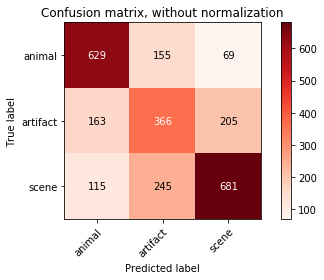

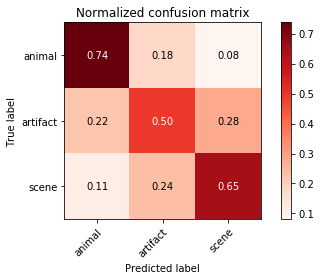

In [21]:
# borrowed from sklearn
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_results, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_results, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')